In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pingouin as pg
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from matplotlib.lines import Line2D
import math
from statsmodels.stats.anova import anova_lm
import seaborn as sns
# To run the matplotlib in command line in Unix, the backend should be configured by the code MPLBACKEND=qt5agg 
# at the beginning of the command
# command line format: MPLBACKEND=qt5agg python directory of the script

/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# 1. Raw data process

## 1.1 Import raw phenotype data

In [2]:
#import data of all the fish for parameters averaged across the four trials
inputfile = '/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Behavior_test/DerivedData/20220822/AccumulativeResults-20201222.xlsx'
df_pheno=pd.read_excel(inputfile,sheet_name=0, index_col=0)

#import data of all the fish for parameters of each trial

df_pheno_trial1 = pd.read_excel(inputfile,sheet_name='Trial1', index_col=0)

df_pheno_trial2 = pd.read_excel(inputfile,sheet_name='Trial2', index_col=0)

df_pheno_trial3 = pd.read_excel(inputfile,sheet_name='Trial3', index_col=0)

df_pheno_trial4 = pd.read_excel(inputfile,sheet_name='Trial4', index_col=0)

In [3]:
#import dark zone travel distance in each trial
df_zone_pheno = pd.read_excel(inputfile,sheet_name=3, index_col=0)
df_zone_pheno = df_zone_pheno.loc[:,df_zone_pheno.columns.str.endswith('D_zone_distance')]
df_zone_pheno.columns = ['T1_DZTD','T2_DZTD','T3_DZTD','T4_DZTD']
df_zone_pheno = df_zone_pheno.fillna(0)

In [4]:
#find the overlapping index among all the datasets
#the final index stands for a list of fish that have been succesfully phenotyped in all four trials and also genotyped
index = df_pheno.index.intersection(df_pheno_trial1.index).intersection(df_pheno_trial2.index).intersection(df_pheno_trial3.index).intersection(df_pheno_trial4.index).intersection(df_zone_pheno.index)
#use the ovearlapping index to slice the dataset of the mean parameter and the dataset of each trial
df_pheno_sub = df_pheno.loc[index]
df_pheno_sub_trial1 = df_pheno_trial1.loc[index]
df_pheno_sub_trial1.columns = 'T1_'+df_pheno_sub_trial1.columns

df_pheno_sub_trial2 = df_pheno_trial2.loc[index]
df_pheno_sub_trial2.columns = 'T2_'+df_pheno_sub_trial2.columns

df_pheno_sub_trial3 = df_pheno_trial3.loc[index]
df_pheno_sub_trial3.columns = 'T3_'+df_pheno_sub_trial3.columns

df_pheno_sub_trial4 = df_pheno_trial4.loc[index]
df_pheno_sub_trial4.columns = 'T4_'+df_pheno_sub_trial4.columns

df_pheno_sub_zone = df_zone_pheno.loc[index]
#add parameter of each trial to the dataset of mean parameters
df_pheno_sub = pd.concat((df_pheno_sub,
                          df_pheno_sub_trial1.iloc[:,1:],
                          df_pheno_sub_trial2.iloc[:,1:],
                          df_pheno_sub_trial3.iloc[:,1:],
                          df_pheno_sub_trial4.iloc[:,1:],df_pheno_sub_zone),axis=1)
df_pheno_sub

,LDCI,PCCI,DET,DEAD,LTFDE,Velocity,TD,Std_LDCIs,DZTD,T1_LDCI,...,T4_PCCI,T4_DET,T4_DEAD,T4_LTFDE,T4_Velocity,T4_TD,T1_DZTD,T2_DZTD,T3_DZTD,T4_DZTD
Fish_ID,,,,,,,,,,,,,,,,,,,,,
20201006_Plate1_1A,-0.339089,-0.230807,13.75,11.840028,4.345925,3.320345,1593.739990,0.279368,555.689250,-0.608395,...,0.253324,13,21.490046,0.000000,2.82815,1357.520020,473.09300,513.7120,448.41400,787.538
20201006_Plate1_1B,-0.416289,-0.856095,13.50,9.565381,31.789450,3.601273,1724.229980,0.256314,506.556775,-0.929255,...,-0.900035,18,17.136857,0.000000,3.83111,1828.719971,50.62110,327.3560,548.11000,1100.140
20201006_Plate1_1C,-0.862876,-0.271084,7.75,3.791210,81.354683,2.635732,1265.032471,0.097093,98.320950,-0.997776,...,-0.154400,16,3.187526,3.636890,2.80289,1345.209961,37.52680,76.1530,116.65900,162.945
20201006_Plate1_1D,-0.865824,-0.407105,9.50,2.981552,80.820770,3.151762,1512.594971,0.111032,132.740075,-0.943432,...,0.286917,21,4.169241,26.325800,3.23934,1554.890015,49.24220,97.5109,84.72220,299.485
20201006_Plate1_1E,-0.796216,-0.759645,4.00,10.887569,240.576508,2.863445,1374.510010,0.205590,167.836200,-0.773353,...,-0.399241,11,11.128575,134.065002,2.93450,1408.569946,135.74900,41.2076,0.00000,326.552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20201117_Plate2_12B,-0.273109,-0.600561,13.75,13.651863,67.632896,3.157433,1515.617554,0.366878,556.036250,-0.655271,...,-0.779558,8,21.260916,44.009800,2.87041,1377.900024,420.20700,902.1930,467.13700,434.608
20201117_Plate2_12C,-0.896176,-0.257097,5.50,7.059820,121.669273,2.450618,1176.421509,0.107724,77.901510,-0.909880,...,-0.016051,12,2.981569,112.911003,2.69867,1295.459961,86.38370,106.9310,2.99134,115.300
20201117_Plate2_12D,-0.878710,-0.935593,5.50,5.322669,232.919998,2.820695,1354.082520,0.124066,109.321925,-0.974318,...,-1.000000,8,4.450077,186.949997,2.60885,1252.339966,45.47170,47.0150,223.09400,121.707


## 1.2 Add three covariables 

In [5]:
def arena_number(df):
    col=int(df[:-1])
    row=df[-1]
    rows=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
    arena = (1-col%2)*8+rows.index(row)+1
    return arena

df_pheno_sub['week'] = df_pheno_sub.index.str[:8]

df_pheno_sub['plate'] = df_pheno_sub.index.str.split('_').str[1]

df_pheno_sub['well'] = df_pheno_sub.index.str.split('_').str[2]

rows=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

df_pheno_sub['arena'] = df_pheno_sub['well'].apply(lambda df: arena_number(df))

def group_number(x):
    return x//2+x%2
df_pheno_sub['group'] = (df_pheno_sub['plate'].str[-1].astype(int)-1)*6+df_pheno_sub['well'].str[:-1].astype(int).\
                apply(lambda x: group_number(x))

df_pheno_sub['group']=df_pheno_sub['group'].astype(object, copy=True)

df_pheno_sub['arena']=df_pheno_sub['arena'].astype(object, copy=True)

df_pheno_sub=df_pheno_sub.dropna()
df_pheno_sub

,LDCI,PCCI,DET,DEAD,LTFDE,Velocity,TD,Std_LDCIs,DZTD,T1_LDCI,...,T4_TD,T1_DZTD,T2_DZTD,T3_DZTD,T4_DZTD,week,plate,well,arena,group
Fish_ID,,,,,,,,,,,,,,,,,,,,,
20201006_Plate1_1A,-0.339089,-0.230807,13.75,11.840028,4.345925,3.320345,1593.739990,0.279368,555.689250,-0.608395,...,1357.520020,473.09300,513.7120,448.41400,787.538,20201006,Plate1,1A,1,1
20201006_Plate1_1B,-0.416289,-0.856095,13.50,9.565381,31.789450,3.601273,1724.229980,0.256314,506.556775,-0.929255,...,1828.719971,50.62110,327.3560,548.11000,1100.140,20201006,Plate1,1B,2,1
20201006_Plate1_1C,-0.862876,-0.271084,7.75,3.791210,81.354683,2.635732,1265.032471,0.097093,98.320950,-0.997776,...,1345.209961,37.52680,76.1530,116.65900,162.945,20201006,Plate1,1C,3,1
20201006_Plate1_1D,-0.865824,-0.407105,9.50,2.981552,80.820770,3.151762,1512.594971,0.111032,132.740075,-0.943432,...,1554.890015,49.24220,97.5109,84.72220,299.485,20201006,Plate1,1D,4,1
20201006_Plate1_1E,-0.796216,-0.759645,4.00,10.887569,240.576508,2.863445,1374.510010,0.205590,167.836200,-0.773353,...,1408.569946,135.74900,41.2076,0.00000,326.552,20201006,Plate1,1E,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20201117_Plate2_12B,-0.273109,-0.600561,13.75,13.651863,67.632896,3.157433,1515.617554,0.366878,556.036250,-0.655271,...,1377.900024,420.20700,902.1930,467.13700,434.608,20201117,Plate2,12B,10,12
20201117_Plate2_12C,-0.896176,-0.257097,5.50,7.059820,121.669273,2.450618,1176.421509,0.107724,77.901510,-0.909880,...,1295.459961,86.38370,106.9310,2.99134,115.300,20201117,Plate2,12C,11,12
20201117_Plate2_12D,-0.878710,-0.935593,5.50,5.322669,232.919998,2.820695,1354.082520,0.124066,109.321925,-0.974318,...,1252.339966,45.47170,47.0150,223.09400,121.707,20201117,Plate2,12D,12,12


In [7]:
df_pheno_sub.sort_values('LDCI')['T1_Velocity']

Fish_ID
20201222_Plate1_1F     1.73341
20200630_Plate2_4D     2.59371
20200218_Plate2_5H     2.39319
20200707_Plate2_7E     1.98284
20200609_Plate1_10A    2.10084
                        ...   
20200630_Plate2_9F     3.20418
20200303_Plate1_7A     2.56126
20200114_Plate1_6A     3.77324
20200317_Plate2_8B     2.76189
20200818_Plate2_1E     3.80942
Name: T1_Velocity, Length: 6151, dtype: float64

## 1.3 Visualize the distribution of each phenotype

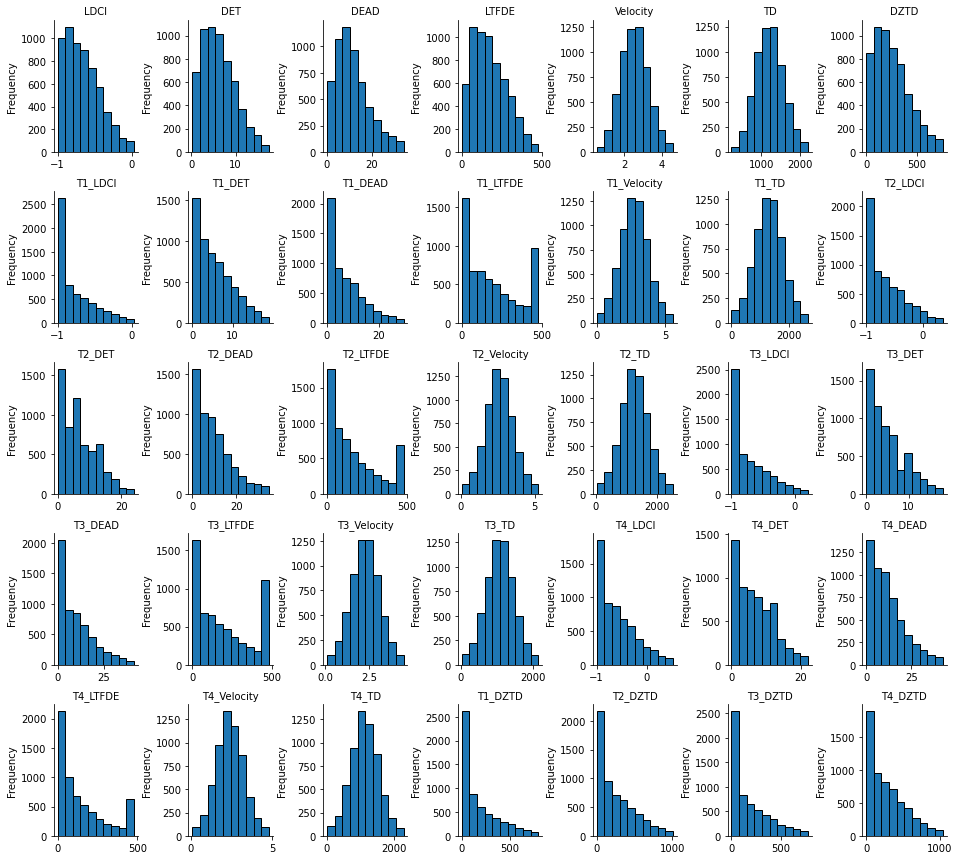

In [6]:
f,ax=plt.subplots(5,7, figsize=(16,15))
plt.subplots_adjust(wspace=0.6,hspace=0.3)

def outliers(x):
    #x is a vector of numbers
    Q1 = x.quantile(0.25)
    Q3 = x.quantile(0.75)
    IQR = Q3 - Q1
    limit1 = Q1 - 1.5*IQR
    limit2 = Q3 + 1.5*IQR
    return x[(x>limit1)&(x<limit2)]
df_raw_plot=df_pheno_sub.iloc[:,:-5].apply(outliers)
df_raw_plot = df_raw_plot.loc[:,~((df_raw_plot.columns.str.contains('PCCI') | df_raw_plot.columns.str.contains('Std')))]

for i, phenotype in enumerate(df_raw_plot.columns):
    ax[i//7][i%7].hist(df_raw_plot[phenotype], bins=10, edgecolor='black')
    ax[i//7][i%7].set_ylabel('Frequency', size=10)
    ax[i//7][i%7].set_title(phenotype, size=10)
    ax[i//7][i%7].spines['right'].set_visible(False)
    ax[i//7][i%7].spines['top'].set_visible(False)

## 1.4 Data cleaning

In [7]:
## Define a class named as processed phenotype or ProPheno to contain all the 
## information of a processed phenotype
class ProPheno():
    
    
    
    #assign attributes to the class
    def __init__(self, pheno, covar ,rawdata):
        self.pheno=pheno #a string for the name of the phenotype
        self.covar=covar #list of covariables 
        self.rawdata=rawdata #raw phenotype data
    #define a method to perform multiple linear regression with the covariables
    def multiple_linear_regression(self):
        formula = self.pheno+'~'+'+'.join(self.covar)
        data = pd.concat((self.rawdata[self.pheno], self.rawdata[self.covar]), axis=1)
        model = smf.ols(formula, data=data).fit()
        anova_table=anova_lm(model)
        return model 
    
    #define a method to export anova analysis of the covariables
    def anova(self):
        return anova_lm(self.multiple_linear_regression())
    
    #define a method to export model summary 
    def model_summary(self):
        return self.multiple_linear_regression().summary()
    
    #define a method to export a processed dataset including
    #raw, fitted, residual and normalized value of the phenotype
    def processed(self):
        raw = self.rawdata[self.pheno]
        fitted_value = self.multiple_linear_regression().predict()
        residual = self.multiple_linear_regression().resid
        qnorm = (residual.rank(pct=True)*0.99).apply(lambda x: stats.norm.ppf(x))
        return pd.DataFrame({'qnorm':qnorm, 'residual':residual, 'fitted':fitted_value, 'raw':raw})
    
    #define a method to find the outliers
    def outliers(self):
        x = self.processed()['qnorm']
        Q1 = x.quantile(0.25)
        Q3 = x.quantile(0.75)
        IQR = Q3 - Q1
        limit1 = Q1 - 1.5*IQR
        limit2 = Q3 + 1.5*IQR
        return x[(x<limit1)|(x>limit2)]
    
    #define a method to exclude the outliers
    def outlier_remove(self):
        outliers = self.outliers().index
        df = self.processed().drop(index=outliers)
        return df
    
    #define a method to get the final dataset for GWAS
    def GWAS_data(self):
        df = self.outlier_remove()
        df.insert(0, 'family', 0)
        df = df.reset_index().set_index('family')
        return df.iloc[:, :2]

In [8]:
## export each phenotype separately for GWAS in wynton
datalist = []

path = '/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Gwas/data/phenotype/20220822/'

for i, pheno in enumerate(df_pheno_sub.columns[:-5]):
    
    processed_pheno_sub = ProPheno(pheno = pheno, covar=['week', 'group', 'arena'], rawdata=df_pheno_sub).GWAS_data()
    
    datalist.append(processed_pheno_sub.set_index('Fish_ID'))
    
    filename = 'pheno_'+pheno+'_pro_20220822.txt'
    
    full_filename = path+str(i+1)+"_"+filename
    
    processed_pheno_sub.to_csv(full_filename, sep =' ', header=False)
    
    print(full_filename)

#combine processed dataset of all phenotype into one dataset
df_propheno_sub = pd.concat(datalist, axis=1, sort=False)
df_propheno_sub.columns = df_pheno_sub.columns[:-5]

/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Gwas/data/phenotype/20220822/1_pheno_LDCI_pro_20220822.txt
/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Gwas/data/phenotype/20220822/2_pheno_PCCI_pro_20220822.txt
/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Gwas/data/phenotype/20220822/3_pheno_DET_pro_20220822.txt
/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Gwas/data/phenotype/20220822/4_pheno_DEAD_pro_20220822.txt
/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Gwas/data/phenotype/20220822/5_pheno_LTFDE_pro_20220822.txt
/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Gwas/data/phenotype/20220822/6_pheno_Velocity_pro_20220822.txt
/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Gwas/data/phenotype/20220822/7_pheno_TD_pro_20220822.txt
/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Gwas/data/phenotype/20220822/8_pheno_Std_LDCIs_pr

In [ ]:
##merge all the phenotype datasets into one dataset
df_metapheno_sub_pro = df_propheno_sub.copy()

df_metapheno_sub_pro.insert(0, 'family', 0)

df_metapheno_sub_pro=df_metapheno_sub_pro.reset_index().rename(columns={'index':'Fish_ID'}).set_index('family')

df_metapheno_sub_pro=df_metapheno_sub_pro.fillna('NA')

df_metapheno_sub_pro.to_csv(path+'metapheno_pro_20220822.txt', 
                  sep =' ', header=False)


In [34]:
df_vda = df_pheno_sub.loc[df_pheno_sub['LDCI']>df_pheno_sub['LDCI'].quantile(0.95)]

df_sda = df_pheno_sub.loc[df_pheno_sub['LDCI']<df_pheno_sub['LDCI'].quantile(0.05)]

dfs = []
for param in df_pheno_sub.iloc[:, [0,2,3,4,5,6,8]].columns:
    df_param_list = []
    for i in range (1,5):
        pop_plot = pd.DataFrame({param:df_pheno_sub['T'+str(i)+'_'+param], 'cat':'pop', 'trial':'T'+str(i)})

        sda_plot = pd.DataFrame({param:df_sda['T'+str(i)+'_'+param], 'cat':'sda', 'trial':'T'+str(i)})

        vda_plot = pd.DataFrame({param:df_vda['T'+str(i)+'_'+param], 'cat':'vda', 'trial':'T'+str(i)})

        df_param_list.append(pd.concat((pop_plot, sda_plot,vda_plot)))
    if param == 'DZTD':
        dfs.append(pd.concat(df_param_list))
    else:
        dfs.append(pd.concat(df_param_list)[param])
df_plot = pd.concat(dfs, axis=1)

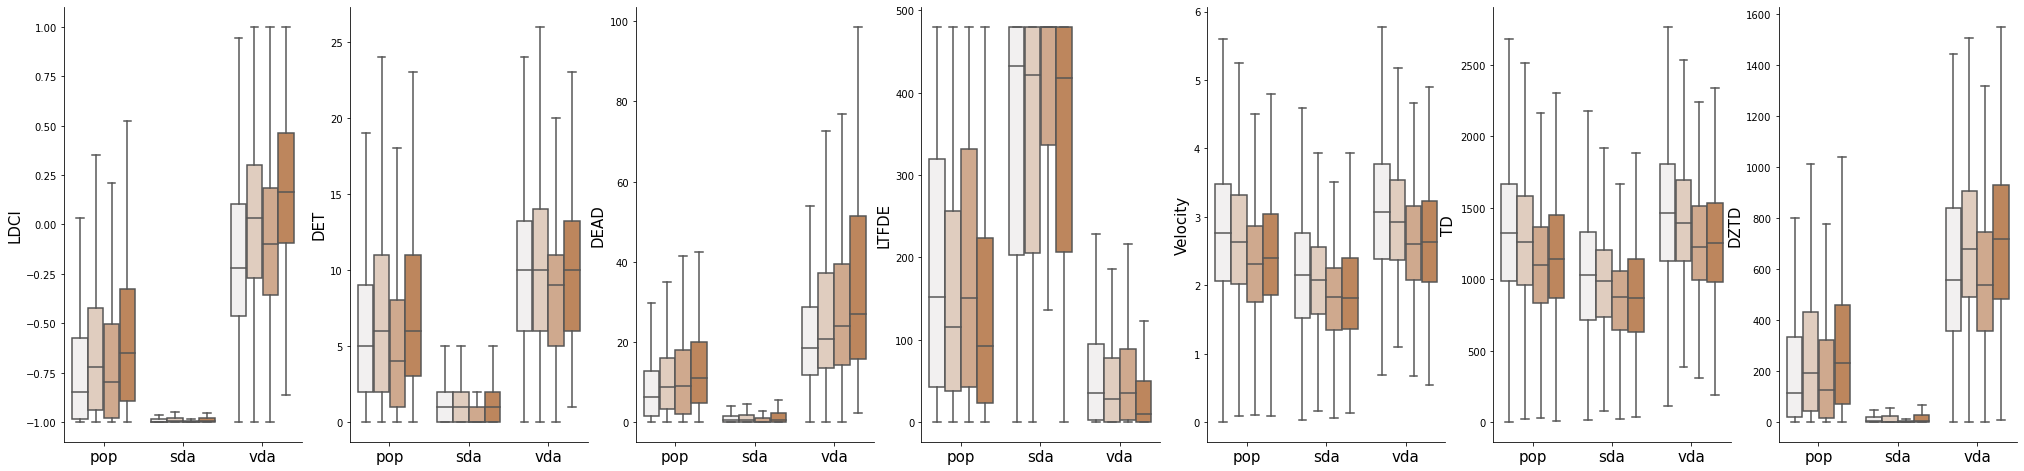

In [53]:

fig, ax = plt.subplots(1, 7, figsize=(35, 8))
for i, param in enumerate(df_plot.columns[:-2]):
    sns.boxplot(x='cat', y=param, hue='trial',data=df_plot[[param, 'cat', 'trial']], ax=ax[i], showfliers = False, color='#cd834d')
    ax[i].legend("",frameon=False, loc = [0.1, 0.9])
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False) 
    ax[i].set_xlabel("")
    ax[i].set_ylabel(param, fontsize=15)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=15)
plt.show()

In [ ]:
df_metapheno_sub_pro.iloc[:0, 1:].to_csv('/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Gwas/data/phenotype/20220822/traits.txt',
                                        sep = ' ')


### Raw Phenotype reformat and output for publications

In [100]:
traits = pd.read_csv('/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Gwas/data/phenotype/20220822/traits.txt',
                                        sep = ' ', header=None)

def trait_convert(traitlist):
    traitlist_new = []
    dic = {'DET':'TDEN', 'DEAD':'ADED', 'LTFDE':'LFDE', 'DZTD':'TDDZ'}
    for element in traitlist:
        if len(element.split('_'))==2 and element.split('_')[1] in list(dic.keys()):
            traitlist_new.append(element.replace(element.split('_')[1], dic[element.split('_')[1]]))
        elif element in list(dic.keys()):
            traitlist_new.append(element.replace(element, dic[element]))
        else:
            traitlist_new.append(element)
    return traitlist_new

del df_raw_plot['PCCI', 'Std_LDCIs', 'T1_PCCI', 'T2_PCCI', 'T3_PCCI', 'T4_PCCI']

df_raw_plot[['PCCI', 'Std_LDCIs', 'T1_PCCI', 'T2_PCCI', 'T3_PCCI', 'T4_PCCI']]=0
df_raw_plot_new = df_raw_plot[traits.iloc[0,1:]]
df_raw_plot_new = df_raw_plot_new.loc[:,~df_raw_plot_new.columns.isin(['PCCI', 'Std_LDCIs', 'T1_PCCI', 'T2_PCCI', 'T3_PCCI', 'T4_PCCI'])]
df_raw_plot_new.columns = (trait_convert(df_raw_plot_new.columns))


fish_id_list = pd.read_excel('/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/doc/Figures/Initial_submit/Table_S1.xlsx',
           sheet_name='Pedigree')['Fish_id']

df_raw_plot_new = df_raw_plot_new.loc[fish_id_list]

df_raw_plot_new.to_csv('/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Gwas/data/phenotype/20220822/raw_phenotype.csv',sep ='\t')


## Phenotypic and genetic correlation of behavioral traits

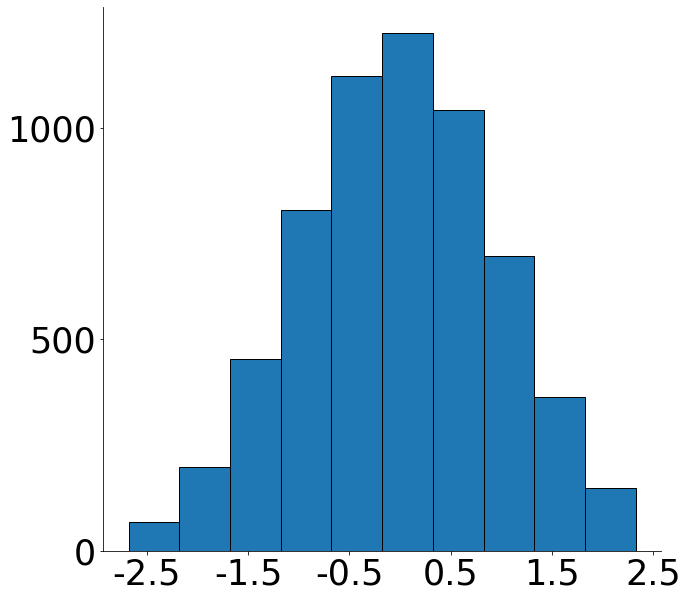

In [64]:
f,ax=plt.subplots(1,1, figsize=(10,10))
ax.hist(df_metapheno_sub_pro[2],bins=10, edgecolor='black')
ax.set_ylabel('', size=15)
ax.set_xlabel('', size=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks(np.arange(-2.5,3.5,1))
ax.set_xticklabels(np.arange(-2.5,3.5,1).round(1), size=35)
ax.set_yticks(np.arange(0,1500,500))
ax.set_yticklabels(np.arange(0,1500,500), size=35)
plt.show()

In [ ]:
## export metaphenotype file for genetic correlation analysis in wynton
df_metapheno_sub_pro = df_propheno_sub.copy()

df_metapheno_sub_pro.insert(0, 'family', 0)

df_metapheno_sub_pro=df_metapheno_sub_pro.reset_index().rename(columns={'index':'Fish_ID'}).set_index('family')
 
df_metapheno_sub_pro=df_metapheno_sub_pro.loc[: ,~df_metapheno_sub_pro.columns.isin(['Trial2_LDCI','Trial3_LDCI','Trial4_LDCI'])]



df_metapheno_sub_GWAS=df_metapheno_sub_pro.fillna('NA')
df_metapheno_sub_GWAS.to_csv('/Users/jialexu/Box/UCSF/Research/Project2GWAS-BehvaioralGenetics/results/20210618/Phenotype_sub/metapheno_sub_pro_0618.txt', 
                  sep =' ', header=False)

In [ ]:
df_metapheno_pro.iloc[:, 1:].hist(bins=50, figsize=(18,12))
plt.show()

### Phenotypic and genetic correlation analysis

In [ ]:
## compute phenotypic correlation coeff. and pval
df_corr=df_propheno_sub.iloc[:,:8].corr()
pheno_corr_pval = pg.pairwise_corr(df_propheno_sub.iloc[:,:8],padjust='bonf', method='spearman').round(3)['p-corr']


In [ ]:
## import genetic correlation coeff. matrix computed on wynton
df_gc = pd.read_csv('/Users/jialexu/Box/UCSF/Research/Project2GWAS-BehvaioralGenetics/results/20210618/gcta/V3/corr_summary.txt',
                   sep = '\t', header=None)

In [ ]:
## extract matrix of genetic correlation coeff. and its se. 
rg = df_gc.iloc[np.arange(0, 83, 3), :]
rg = rg.iloc[:, 1:]
rg.columns = ['corr_coeff', 'se']

In [ ]:
## extract matrix of one-tailed pairwise pval
## the column and index is the same as the column of the metaphenotype dataset
pval = df_gc.iloc[np.arange(2, 84, 3), :2]
pval['pval_one-tailed'] = pval[1].str.split('(').str[0]
pval['pval_one-tailed']=pval['pval_one-tailed'].astype('float32')
## compute two-tailed pval based on one-tailed pval
pval['pval_two-tailed']=pval['pval_one-tailed']*2
pval = pval.iloc[:, 2:]
geno_corr_pval = pval['pval_two-tailed']

In [ ]:
## combine genetic corr and phenotypic corr into one matrix

## create an upper triangle matrix with genetic corr. coeff
a= np.full((8,8),1, dtype='float32')
triu = np.triu_indices(8,1)
tril = np.tril_indices(8,-1)
a[triu]=list(rg['corr_coeff'])
## fill the lower triangle matrix with phenotypic corr. coeff
a[tril]=np.array(df_corr)[tril]

##add column and index to this combined corr. matrix 
##both the column and the index are identical to the column of metaphenotype dataset 
df_phenogeno_corr = pd.DataFrame(a)
df_phenogeno_corr.columns=df_corr.columns
df_phenogeno_corr.index = df_corr.index
df_phenogeno_corr

In [ ]:
## combine pval of genetic corr and phenotypic corr into one matrix

## create an upper triangle matrix with genetic corr. coeff
a= np.full((8,8),-1, dtype='float32')
triu = np.triu_indices(8,1)
tril = np.tril_indices(8,-1)
a[triu]=list(pheno_corr_pval)
a = a.T
a[triu]=list(geno_corr_pval)

##add column and index to this combined corr. matrix 
##both the column and the index are identical to the column of metaphenotype dataset 
df_phenogeno_pval = pd.DataFrame(a)
df_phenogeno_pval.columns=df_corr.columns
df_phenogeno_pval.index = df_corr.index
df_phenogeno_pval

In [ ]:
## plot the genetic and phenotypic correlation in a heatmap
## the color is based on the corr.coeff
## the significance is based on pval and is designated with symbol 

# make a function to convert pval to symbol to indicate significance
def annotate_pval(x):
    if x ==-1:
        return ''
    if x>0.05:
        return round(x, 2)
    elif x<0.05 and x >0.01:
        return '*'
    else:
        return '**'
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap
f, ax=plt.subplots(figsize=(30,6))
sns.heatmap(df_phenogeno_corr.round(2), cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.8,'label':'Corr.Coeff.'}, \
            annot=None,annot_kws={'fontsize':12}, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30,horizontalalignment='right', fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30,horizontalalignment='right',fontsize=12)
ax.figure.axes[-1].yaxis.label.set_size(12)
ax.figure.axes[-1].set_yticklabels(ax.figure.axes[-1].get_yticklabels(),fontsize=15)
ax.figure.axes[-1].yaxis.tick_left()
for i in range(0, 8):
    for j in range (0, 8):
        pval = df_phenogeno_pval.iloc[i, j]
        
        ax.text(j+0.3, i+0.6, annotate_pval(pval))
#plt.savefig('figS3.pdf',bbox_inches = 'tight',
    #pad_inches = 0)
plt.show()

In [ ]:
df_her = pd.read_csv('/Users/jialexu/Library/CloudStorage/Box-Box/UCSF/Research/Project2GWAS-BehvaioralGenetics/experiments/Gwas/data/Heritability/Heritability_summary_20211215.txt',
                   sep = '\t', header=None)


df_her.index = df_li.columns[:-5]

df_her = df_her.iloc[:, 1:]
df_her.columns = ['Heritability', 'Se']

df_her = df_her.sort_values(by='Heritability', ascending=False)

df_her.to_excel('/Users/jialexu/Library/CloudStorage/Box-Box/UCSF/Research/Project2GWAS-BehvaioralGenetics/experiments/Gwas/data/Heritability/Heritability_summary_20211215.xlsx')



In [ ]:
df_li.columns

In [ ]:
import matplotlib.colors as mcolors
f, ax = plt.subplots(1,1, figsize=(24,12))
cmap = mcolors.LinearSegmentedColormap.from_list("", ["red", "yellow", "green"])
ax.bar(data=df_her, x=np.arange(0,30,1),
       height=df_her['Heritability'],yerr=df_her['Se'], 
       capsize=10, color=cmap(df_her.iloc[:,0].values/df_her.iloc[:,0].max()))
ax.set_xticks(np.arange(0,30,1))
ax.set_xticklabels(list(df_her.index), size=15, rotation=30,horizontalalignment='right')
ax.tick_params(axis='y', labelsize=20)
ax.set_ylabel('Heritability',size=30)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for i, v in enumerate(df_her['Heritability']):
    ax.text(i-0.4,v+0.04, str(round(v*100,1))+'%', color='blue', fontweight='bold')

In [ ]:
df_her.iloc[:15]

In [ ]:
for parameter in df_her.index:
    order = list(df_li.columns).index(parameter)
    print('%i %s'%(order+1, parameter))

## 1.5 Output SDA and VDA list with different percentile

In [ ]:
df_SDA_10=pheno_LDCIpro_0310.loc[pheno_LDCIpro_0310['qnorm']<pheno_LDCIpro_0310['qnorm'].quantile(0.1)]
df_VDA_10=pheno_LDCIpro_0310.loc[pheno_LDCIpro_0310['qnorm']>pheno_LDCIpro_0310['qnorm'].quantile(0.9)]

df_SDA_5=pheno_LDCIpro_0310.loc[pheno_LDCIpro_0310['qnorm']<pheno_LDCIpro_0310['qnorm'].quantile(0.05)]
df_VDA_5=pheno_LDCIpro_0310.loc[pheno_LDCIpro_0310['qnorm']>pheno_LDCIpro_0310['qnorm'].quantile(0.95)]

df_SDA_1=pheno_LDCIpro_0310.loc[pheno_LDCIpro_0310['qnorm']<pheno_LDCIpro_0310['qnorm'].quantile(0.01)]
df_VDA_1=pheno_LDCIpro_0310.loc[pheno_LDCIpro_0310['qnorm']>pheno_LDCIpro_0310['qnorm'].quantile(0.99)]

df_SDA_10['Fish_ID'].to_csv('/Users/jialexu/Documents/BioinformaticAtmosphere/Data/GWAS/Phenotype/SDA_10.txt', \
               sep=' ', header=False, index=False)
df_VDA_10['Fish_ID'].to_csv('/Users/jialexu/Documents/BioinformaticAtmosphere/Data/GWAS/Phenotype/VDA_10.txt', \
               sep=' ', header=False, index=False)
df_SDA_5['Fish_ID'].to_csv('/Users/jialexu/Documents/BioinformaticAtmosphere/Data/GWAS/Phenotype/SDA_5.txt', \
               sep=' ', header=False, index=False)
df_VDA_5['Fish_ID'].to_csv('/Users/jialexu/Documents/BioinformaticAtmosphere/Data/GWAS/Phenotype/VDA_5.txt', \
               sep=' ', header=False, index=False)
df_SDA_1['Fish_ID'].to_csv('/Users/jialexu/Documents/BioinformaticAtmosphere/Data/GWAS/Phenotype/SDA_1.txt', \
               sep=' ', header=False, index=False)
df_VDA_1['Fish_ID'].to_csv('/Users/jialexu/Documents/BioinformaticAtmosphere/Data/GWAS/Phenotype/VDA_1.txt', \
               sep=' ', header=False, index=False)

# 2. Adjust phenotype using one GWAS detected SNP as a covariate

In [ ]:
df_gwassnp_vcf=pd.read_csv('/Users/jialexu/Box/UCSF/Research/Project2GWAS-BehvaioralGenetics/results/20210618/Association/Indpendency_test/chr16_vcf_T1_peak_snp.txt',
                          sep='\t')

df_peak_snp_geno = df_gwassnp_vcf.iloc[:, 9:].apply(lambda x: x.str[0].astype('int')+x.str[2].astype('int')).transpose().sort_values(by=0)


In [ ]:
df_peak_snp_geno.columns = df_gwassnp_vcf['#CHROM']+'_'+df_gwassnp_vcf['POS'].astype('str')

In [ ]:
df_peak_snp_geno

In [ ]:
#pick the top snp of one chromosome and add it into the phenotype dataset as a covariate
df_pheno_snpex=pd.concat((df_pheno_sub,df_peak_snp_geno),axis=1, sort=False).dropna()

In [ ]:
df_pheno_snpex=df_pheno_snpex.rename_axis('Fish_ID')

In [ ]:
df_pheno_snpex

In [ ]:
## export each phenotype separately for GWAS in wynton
peaksnp_adjusted_pheno_list = []

path = '/Users/jialexu/Box/UCSF/Research/Project2GWAS-BehvaioralGenetics/results/20210618/Phenotype/'
filename = 'peaksnp_adjusted_pheno.txt'
full_filename =path+filename
for pheno in df_pheno_sub.columns[:11]:
    
    processed_pheno_sub = ProPheno(pheno = pheno, covar=['week', 'group', 'arena','chr16_12559604'], rawdata=df_pheno_snpex).GWAS_data()
    
    peaksnp_adjusted_pheno_list.append(processed_pheno_sub.set_index('Fish_ID'))


#combine processed dataset of all phenotype into one dataset
df_peaksnp_adjusted_pheno = pd.concat(peaksnp_adjusted_pheno_list, axis=1, sort=False)
df_peaksnp_adjusted_pheno.columns = df_pheno_snpex.columns[:11]


df_peaksnp_adjusted_pheno_output = df_peaksnp_adjusted_pheno.rename_axis('Fish_ID')

df_peaksnp_adjusted_pheno_output=df_peaksnp_adjusted_pheno_output.reset_index()

df_peaksnp_adjusted_pheno_output.insert(0, 'famliy', 0)

df_peaksnp_adjusted_pheno_output.to_csv(full_filename, sep =' ', header=False, index=False)